In [0]:
import _pickle as cPickle
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as it
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
import keras.models as models
from keras.layers.convolutional import Convolution2D, ZeroPadding2D
from keras.regularizers import *
from keras.optimizers import adam
from sklearn.metrics import confusion_matrix
plt.rcParams['figure.figsize'] = [15, 15]
from tqdm import trange, tqdm

Using TensorFlow backend.


# 1. Download Data

In [0]:
!wget http://opendata.deepsig.io/datasets/2016.10/RML2016.10b.tar.bz2

--2019-05-08 09:58:41--  http://opendata.deepsig.io/datasets/2016.10/RML2016.10b.tar.bz2
Resolving opendata.deepsig.io (opendata.deepsig.io)... 52.14.91.165
Connecting to opendata.deepsig.io (opendata.deepsig.io)|52.14.91.165|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1245608913 (1.2G) [application/x-bzip2]
Saving to: ‘RML2016.10b.tar.bz2’

RML2016.10b.tar.bz2 100%[===================>]   1.16G  7.80MB/s    in 3m 4s   

2019-05-08 10:01:51 (6.44 MB/s) - ‘RML2016.10b.tar.bz2’ saved [1245608913/1245608913]



In [0]:
!tar xf RML2016.10b.tar.bz2

In [0]:
Xd = cPickle.load(open("RML2016.10b.dat",'rb'),encoding = 'bytes')

In [0]:
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = list()  
lbl = list()
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)
lbl = np.array(lbl)
print(X.shape)
print(lbl.shape)

(1200000, 2, 128)
(1200000, 2)


**Formatting Data.**

In [0]:
data = list()  #1200000 example col[0] -> I-Signal col[1] -> Q-Signal col[2] -> SNR
label = list() #1200000 label (Mod) for examples
# data.clear();
label.clear(); #Clearing to not overloading RAMs.

for i in range(len(X)): 
  data.append([X[i][0],X[i][1],lbl[i][1]])
  label.append(lbl[i][0])
  
data = np.array(data);
label = np.array(label) #Numpyzing lists
Xd.clear() #Kill them Now!

print(label.shape)

(1200000,)


# 2. Create feature Spaces

In [0]:
def getFeatureSpaces(data):
  feature_space = list()
  feature_space.clear()
  for i in tqdm(range(len(data))):
    I_signal = np.array(data[i][0])
    Q_signal = np.array(data[i][1])   
    diff_I = np.array(np.diff(data[i][0]))
    diff_Q = np.array(np.diff(data[i][1])) 
    int_I = it.cumtrapz(data[i][0],initial=0)
    int_Q = it.cumtrapz(data[i][1],initial=0) 
    feature_space.append([I_signal,Q_signal,diff_I,diff_Q,int_I,int_Q,np.add(diff_I,I_signal[1:]),np.add(diff_Q,Q_signal[1:])])
  return np.array(feature_space)

feature_space = getFeatureSpaces(data)

100%|██████████| 1200000/1200000 [00:54<00:00, 22080.57it/s]


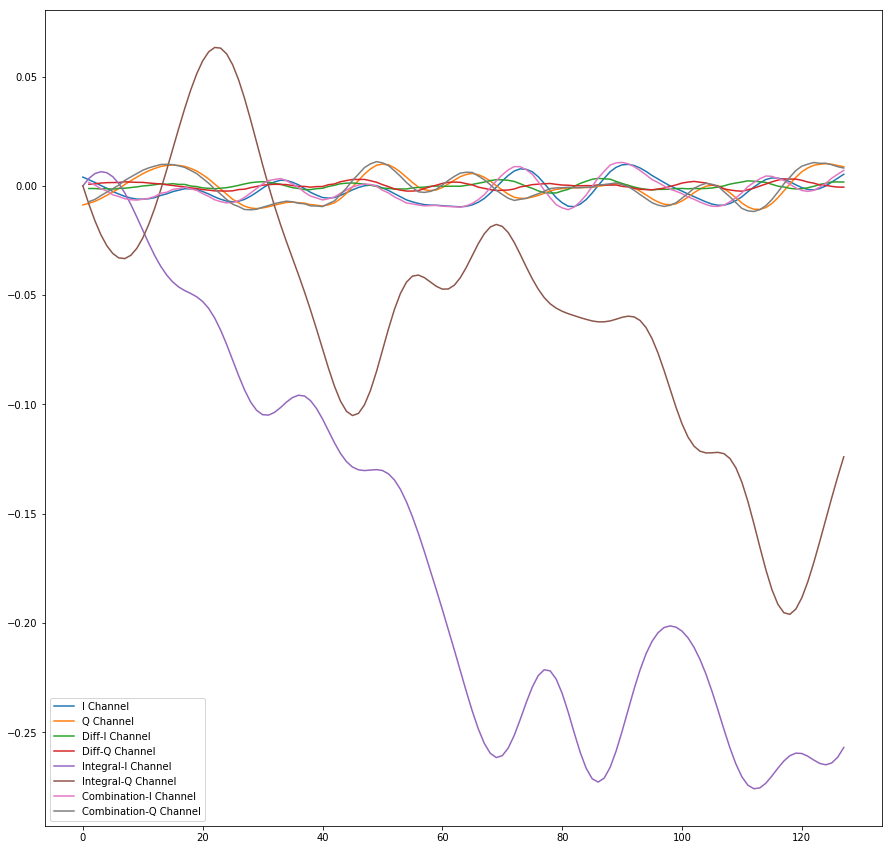

In [0]:
# arr = np.array(feature_space[0:600000][:,4:6])
# print(arr[0][0].shape)
plt.figure()
plt.plot(range(0,128),feature_space[119999][0],label = "I Channel")
plt.plot(range(0,128),feature_space[119999][1],label = "Q Channel")
plt.plot(range(1,128),feature_space[119999][2],label = "Diff-I Channel")
plt.plot(range(1,128),feature_space[119999][3],label = "Diff-Q Channel")
plt.plot(range(0,128),feature_space[119999][4],label = "Integral-I Channel")
plt.plot(range(0,128),feature_space[119999][5],label = "Integral-Q Channel")
plt.plot(range(1,128),feature_space[119999][6],label = "Combination-I Channel")
plt.plot(range(1,128),feature_space[119999][7],label = "Combination-Q Channel")
plt.legend(loc='lower left')

# 3. Supervised Learning Step

**Split the data into 50% for training/validation and 50% for testing.**

In [0]:
#Training data.
train_data = X[::2]
train_lbl = label[::2]

# Test data.
test_data = X[1::2]
test_lbl = label[1::2]

# Getting a part for validation :$
validation_data = test_data[::20]
validation_label = test_lbl[::20]

train_data = np.array(train_data); test_data = np.array(test_data); train_lbl = np.array(train_lbl); test_lbl = np.array(test_lbl)# Numpyzing 
validation_data = np.array(validation_data); validation_label = np.array(validation_label)

test_data_w_v = list()
test_label_w_v = list()


j = 0
for i in trange(len(test_data)):
  if i % 20 == 0:
    j = j + 1
    continue
  test_data_w_v.append(test_data[j])
  test_label_w_v.append(test_lbl[j])
  j = j + 1
  
test_data = np.array(test_data_w_v)
test_lbl = np.array(test_label_w_v)

del test_data_w_v
del test_label_w_v

print(train_data.shape)
print(test_lbl.shape)

100%|██████████| 600000/600000 [00:00<00:00, 1074073.61it/s]


(600000, 2, 128)
(570000,)


## Building CNN

In [0]:
in_shp = list(train_data.shape[1:])
print([1]+in_shp)
print(in_shp)
classes = mods
model = models.Sequential()

dr = 0.5 # dropout rate (%)
model = models.Sequential()

model.add(Reshape([1]+in_shp, input_shape=in_shp))                                                  #reshape output to [1,2,128]
model.add(ZeroPadding2D((0, 2)))
model.add(Convolution2D(64, (1, 3),  activation="relu", name="conv1",data_format='channels_first'))
model.add(Dropout(dr))                                                                              # helps prevent overfitting by setting a number of i/ps to 0
model.add(ZeroPadding2D((0, 2)))
model.add(Convolution2D(16, (2, 3),  activation="relu", name="conv2",data_format='channels_first'))
model.add(Dropout(dr))
model.add(Flatten())                                                                                #transition from conv to dense, must flatten
model.add(Dense(126, activation='relu', name="dense1"))                                             #output = activation(dot(input, kernel) + bias)
model.add(Dropout(dr))
model.add(Dense(10, name="dense2" ))
model.add(Activation('softmax'))
model.add(Reshape([10]))
model.summary()

[1, 2, 128]
[2, 128]
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 1, 2, 128)         0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 1, 6, 128)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 6, 126)        256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 6, 126)        0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 64, 10, 126)       0         
_________________________________________________________________


### Encoding labels

In [0]:
# keras.utils.to_categorical(train_lbl, num_classes=10, dtype='float32')
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(train_lbl)
valid_labels_encoded = label_encoder.fit_transform(validation_label)
test_lbl_encoded = label_encoder.fit_transform(test_lbl)

### FItting model


In [0]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model.fit(train_data, labels_encoded, epochs=100, batch_size=1024, verbose =2, validation_data=(validation_data, valid_labels_encoded), callbacks =[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')])

Instructions for updating:
Use tf.cast instead.
Train on 600000 samples, validate on 30000 samples
Epoch 1/100
 - 46s - loss: 1.9182 - acc: 0.2410 - val_loss: 1.6001 - val_acc: 0.3598
Epoch 2/100
 - 42s - loss: 1.5993 - acc: 0.3523 - val_loss: 1.3965 - val_acc: 0.4410
Epoch 3/100
 - 42s - loss: 1.5274 - acc: 0.3770 - val_loss: 1.3740 - val_acc: 0.4276
Epoch 4/100
 - 43s - loss: 1.5057 - acc: 0.3854 - val_loss: 1.3458 - val_acc: 0.4395
Epoch 5/100
 - 43s - loss: 1.4895 - acc: 0.3908 - val_loss: 1.3813 - val_acc: 0.4108
Epoch 6/100
 - 43s - loss: 1.4716 - acc: 0.3979 - val_loss: 1.3279 - val_acc: 0.4407
Epoch 7/100
 - 44s - loss: 1.4539 - acc: 0.4044 - val_loss: 1.2880 - val_acc: 0.4629
Epoch 8/100
 - 44s - loss: 1.4349 - acc: 0.4096 - val_loss: 1.2874 - val_acc: 0.4606
Epoch 9/100
 - 44s - loss: 1.4239 - acc: 0.4146 - val_loss: 1.2841 - val_acc: 0.4613
Epoch 10/100
 - 44s - loss: 1.4173 - acc: 0.4163 - val_loss: 1.2791 - val_acc: 0.4642
Epoch 11/100
 - 44s - loss: 1.4120 - acc: 0.4181 -

### Evaluating on test set

In [0]:
from sklearn.metrics import confusion_matrix
rounded_pred = model.predict_classes(test_data,batch_size = 10)
print(rounded_pred)
cm = confusion_matrix(test_lbl_encoded, rounded_pred)
print(cm)
score = model.evaluate(test_data, test_lbl_encoded, verbose=0, batch_size=10)
print('loss','accuracy:')
print(score)

[3 0 0 ... 1 1 1]
[[21019  1416  2541 12415  1781    24   766   681 15816   541]
 [ 4571 41284  1457  2592  1291     9    10     0  1918  3868]
 [ 8507  1479 37780  5147  1057   500    49    13  1832   636]
 [ 8817  1452  2314 39512  2360    30   101    56  1786   572]
 [ 6693  2141  1920  6528 35522    26    56    44  1647  2423]
 [ 6046  1085  9597  3949   899 33622    51    11  1323   417]
 [11772   800  1783  6340  1144   181  4267 27510  2861   342]
 [ 8863   515  1269  5182   911   192  3750 34356  1699   263]
 [18000  1395  2612 12787  1674    28   701   666 18565   572]
 [ 4809 30167  1510  2952  4574    11    15     4  1896 11062]]
loss accuracy:
[1.2271195331455895, 0.4859456142857671]


## ANN and Tuning

In [0]:
def tuneItNowNow(layers,neurons):
  print('\nLayers = ', layers, "Neurons = ",neurons)
  print("----------------------------------------")
  in_shp = list(train_data.shape[1:])
  model = models.Sequential()
  model.add(Reshape([1]+in_shp, input_shape=in_shp))
  for i in range(layers):
    model.add(Dense(neurons,activation='relu'))  
  model.add(Flatten())
  model.add(Dense(10))
  model.add(Activation('softmax'))
  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])
  model.fit(train_data, labels_encoded, epochs=5, batch_size=1024, verbose =2, validation_data=(validation_data, valid_labels_encoded), callbacks =[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')])
  #score = model.evaluate(test_data, test_lbl_encoded, verbose=0, batch_size=10)
  #print('loss','accuracy:')
  #print(score)

i = [i for i in range(3,10)]
j = [2**i for i in range(9,13)]
for k in tqdm(i):
  for c in tqdm(j):
    tuneItNowNow(k,c)

  0%|          | 0/4 [00:00<?, ?it/s]


Layers =  3 Neurons =  512
----------------------------------------
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 600000 samples, validate on 30000 samples
Epoch 1/5
 - 7s - loss: 1.6696 - acc: 0.3327 - val_loss: 1.4950 - val_acc: 0.3945
Epoch 2/5
 - 3s - loss: 1.4706 - acc: 0.4010 - val_loss: 1.4492 - val_acc: 0.4106
Epoch 3/5
 - 3s - loss: 1.4364 - acc: 0.4146 - val_loss: 1.4273 - val_acc: 0.4179
Epoch 4/5
 - 3s - loss: 1.4175 - acc: 0.4230 - val_loss: 1.4214 - val_acc: 0.4185
Epoch 5/5
 - 3s - loss: 1.4043 - acc: 0.4278 - val_loss: 1.4109 - val_acc: 0.4266



 25%|██▌       | 1/4 [00:20<01:02, 20.73s/it]


Layers =  3 Neurons =  1024
----------------------------------------
Train on 600000 samples, validate on 30000 samples
Epoch 1/5
 - 8s - loss: 1.6090 - acc: 0.3502 - val_loss: 1.4768 - val_acc: 0.3973
Epoch 2/5
 - 7s - loss: 1.4395 - acc: 0.4116 - val_loss: 1.4249 - val_acc: 0.4170
Epoch 3/5
 - 7s - loss: 1.4057 - acc: 0.4249 - val_loss: 1.3968 - val_acc: 0.4318
Epoch 4/5
 - 7s - loss: 1.3431 - acc: 0.4509 - val_loss: 1.3302 - val_acc: 0.4515
Epoch 5/5
 - 8s - loss: 1.2913 - acc: 0.4700 - val_loss: 1.2869 - val_acc: 0.4703



 50%|█████     | 2/4 [00:58<00:51, 25.77s/it]


Layers =  3 Neurons =  2048
----------------------------------------
Train on 600000 samples, validate on 30000 samples
Epoch 1/5
 - 25s - loss: 1.5708 - acc: 0.3626 - val_loss: 1.4504 - val_acc: 0.4083
Epoch 2/5
 - 24s - loss: 1.4157 - acc: 0.4204 - val_loss: 1.3581 - val_acc: 0.4407
Epoch 3/5
 - 24s - loss: 1.3200 - acc: 0.4587 - val_loss: 1.3035 - val_acc: 0.4626
Epoch 4/5
 - 24s - loss: 1.2643 - acc: 0.4783 - val_loss: 1.2654 - val_acc: 0.4692
Epoch 5/5
 - 24s - loss: 1.2209 - acc: 0.4931 - val_loss: 1.2412 - val_acc: 0.4856



 75%|███████▌  | 3/4 [03:00<00:54, 54.67s/it]


Layers =  3 Neurons =  4096
----------------------------------------
Train on 600000 samples, validate on 30000 samples
Epoch 1/5
 - 77s - loss: 1.5609 - acc: 0.3656 - val_loss: 1.4503 - val_acc: 0.4043
Epoch 2/5
 - 75s - loss: 1.3753 - acc: 0.4366 - val_loss: 1.4000 - val_acc: 0.4322
Epoch 3/5
 - 75s - loss: 1.2779 - acc: 0.4736 - val_loss: 1.2849 - val_acc: 0.4639
Epoch 4/5
 - 75s - loss: 1.2138 - acc: 0.4959 - val_loss: 1.3086 - val_acc: 0.4615
Epoch 5/5
 - 75s - loss: 1.1639 - acc: 0.5151 - val_loss: 1.1939 - val_acc: 0.5020



  0%|          | 0/4 [00:00<?, ?it/s]


Layers =  4 Neurons =  512
----------------------------------------
Train on 600000 samples, validate on 30000 samples
Epoch 1/5
 - 5s - loss: 1.6303 - acc: 0.3402 - val_loss: 1.4883 - val_acc: 0.3874
Epoch 2/5
 - 4s - loss: 1.4474 - acc: 0.4083 - val_loss: 1.4283 - val_acc: 0.4222
Epoch 3/5
 - 4s - loss: 1.4200 - acc: 0.4209 - val_loss: 1.4378 - val_acc: 0.4059
Epoch 4/5
 - 4s - loss: 1.3936 - acc: 0.4321 - val_loss: 1.4193 - val_acc: 0.4199
Epoch 5/5
 - 4s - loss: 1.3403 - acc: 0.4527 - val_loss: 1.3256 - val_acc: 0.4573



 25%|██▌       | 1/4 [00:22<01:07, 22.39s/it]


Layers =  4 Neurons =  1024
----------------------------------------
Train on 600000 samples, validate on 30000 samples
Epoch 1/5
 - 11s - loss: 1.5797 - acc: 0.3579 - val_loss: 1.4498 - val_acc: 0.4103
Epoch 2/5
 - 10s - loss: 1.4179 - acc: 0.4199 - val_loss: 1.3876 - val_acc: 0.4288
Epoch 3/5
 - 10s - loss: 1.3429 - acc: 0.4492 - val_loss: 1.3668 - val_acc: 0.4425
Epoch 4/5
 - 10s - loss: 1.2806 - acc: 0.4727 - val_loss: 1.2837 - val_acc: 0.4677
Epoch 5/5
 - 10s - loss: 1.2558 - acc: 0.4810 - val_loss: 1.2715 - val_acc: 0.4741



 50%|█████     | 2/4 [01:15<01:03, 31.65s/it]


Layers =  4 Neurons =  2048
----------------------------------------
Train on 600000 samples, validate on 30000 samples
Epoch 1/5
 - 36s - loss: 1.5606 - acc: 0.3646 - val_loss: 1.4187 - val_acc: 0.4235
Epoch 2/5
 - 36s - loss: 1.3882 - acc: 0.4311 - val_loss: 1.3347 - val_acc: 0.4511
Epoch 3/5
 - 35s - loss: 1.2968 - acc: 0.4668 - val_loss: 1.2906 - val_acc: 0.4668
Epoch 4/5
 - 35s - loss: 1.2500 - acc: 0.4830 - val_loss: 1.2580 - val_acc: 0.4793
Epoch 5/5
 - 34s - loss: 1.2190 - acc: 0.4932 - val_loss: 1.2687 - val_acc: 0.4730



 75%|███████▌  | 3/4 [04:12<01:15, 75.20s/it]


Layers =  4 Neurons =  4096
----------------------------------------
Train on 600000 samples, validate on 30000 samples
Epoch 1/5
 - 112s - loss: 1.5593 - acc: 0.3655 - val_loss: 1.4275 - val_acc: 0.4123
Epoch 2/5
 - 109s - loss: 1.3585 - acc: 0.4438 - val_loss: 1.3379 - val_acc: 0.4401
Epoch 3/5
 - 109s - loss: 1.2743 - acc: 0.4747 - val_loss: 1.2704 - val_acc: 0.4770
Epoch 4/5
 - 109s - loss: 1.2166 - acc: 0.4954 - val_loss: 1.2316 - val_acc: 0.4911
Epoch 5/5
 - 109s - loss: 1.1564 - acc: 0.5183 - val_loss: 1.1877 - val_acc: 0.5043



  0%|          | 0/4 [00:00<?, ?it/s]


Layers =  5 Neurons =  512
----------------------------------------
Train on 600000 samples, validate on 30000 samples
Epoch 1/5
 - 6s - loss: 1.6238 - acc: 0.3408 - val_loss: 1.4479 - val_acc: 0.4123
Epoch 2/5
 - 5s - loss: 1.4244 - acc: 0.4168 - val_loss: 1.4566 - val_acc: 0.3978
Epoch 3/5
 - 5s - loss: 1.3484 - acc: 0.4481 - val_loss: 1.3229 - val_acc: 0.4595
Epoch 4/5
 - 5s - loss: 1.3088 - acc: 0.4630 - val_loss: 1.2923 - val_acc: 0.4700
Epoch 5/5
 - 5s - loss: 1.2813 - acc: 0.4721 - val_loss: 1.2878 - val_acc: 0.4699



 25%|██▌       | 1/4 [00:26<01:19, 26.50s/it]


Layers =  5 Neurons =  1024
----------------------------------------
Train on 600000 samples, validate on 30000 samples
Epoch 1/5
 - 14s - loss: 1.5714 - acc: 0.3612 - val_loss: 1.4222 - val_acc: 0.4217
Epoch 2/5
 - 13s - loss: 1.3811 - acc: 0.4339 - val_loss: 1.3309 - val_acc: 0.4548
Epoch 3/5
 - 13s - loss: 1.2997 - acc: 0.4663 - val_loss: 1.2957 - val_acc: 0.4687
Epoch 4/5
 - 13s - loss: 1.2658 - acc: 0.4776 - val_loss: 1.2975 - val_acc: 0.4581
Epoch 5/5
 - 13s - loss: 1.2432 - acc: 0.4853 - val_loss: 1.2781 - val_acc: 0.4760



 50%|█████     | 2/4 [01:33<01:17, 38.79s/it]


Layers =  5 Neurons =  2048
----------------------------------------
Train on 600000 samples, validate on 30000 samples
Epoch 1/5
 - 46s - loss: 1.5846 - acc: 0.3545 - val_loss: 1.4086 - val_acc: 0.4269
Epoch 2/5
 - 44s - loss: 1.3577 - acc: 0.4430 - val_loss: 1.2935 - val_acc: 0.4642
Epoch 3/5
 - 44s - loss: 1.2832 - acc: 0.4719 - val_loss: 1.2828 - val_acc: 0.4713
Epoch 4/5
 - 44s - loss: 1.2483 - acc: 0.4836 - val_loss: 1.2638 - val_acc: 0.4770
Epoch 5/5
 - 44s - loss: 1.2117 - acc: 0.4956 - val_loss: 1.2372 - val_acc: 0.4875



 75%|███████▌  | 3/4 [05:17<01:34, 94.25s/it]


Layers =  5 Neurons =  4096
----------------------------------------
Train on 600000 samples, validate on 30000 samples
Epoch 1/5
 - 147s - loss: 1.5549 - acc: 0.3649 - val_loss: 1.4312 - val_acc: 0.4157
Epoch 2/5
 - 143s - loss: 1.3651 - acc: 0.4404 - val_loss: 1.3169 - val_acc: 0.4552
Epoch 3/5
 - 143s - loss: 1.2794 - acc: 0.4723 - val_loss: 1.2644 - val_acc: 0.4769
Epoch 4/5
 - 142s - loss: 1.2267 - acc: 0.4904 - val_loss: 1.2393 - val_acc: 0.4823
Epoch 5/5
 - 143s - loss: 1.1677 - acc: 0.5129 - val_loss: 1.2274 - val_acc: 0.4868



  0%|          | 0/4 [00:00<?, ?it/s]


Layers =  6 Neurons =  512
----------------------------------------
Train on 600000 samples, validate on 30000 samples
Epoch 1/5
 - 7s - loss: 1.6135 - acc: 0.3436 - val_loss: 1.4650 - val_acc: 0.4069
Epoch 2/5
 - 6s - loss: 1.4098 - acc: 0.4217 - val_loss: 1.3528 - val_acc: 0.4485
Epoch 3/5
 - 6s - loss: 1.3303 - acc: 0.4548 - val_loss: 1.3174 - val_acc: 0.4559
Epoch 4/5
 - 6s - loss: 1.2968 - acc: 0.4666 - val_loss: 1.3017 - val_acc: 0.4555
Epoch 5/5
 - 6s - loss: 1.2777 - acc: 0.4734 - val_loss: 1.2880 - val_acc: 0.4689



 25%|██▌       | 1/4 [00:31<01:34, 31.39s/it]


Layers =  6 Neurons =  1024
----------------------------------------
Train on 600000 samples, validate on 30000 samples
Epoch 1/5
 - 18s - loss: 1.5817 - acc: 0.3557 - val_loss: 1.4393 - val_acc: 0.3989
Epoch 2/5
 - 16s - loss: 1.3654 - acc: 0.4409 - val_loss: 1.3033 - val_acc: 0.4652
Epoch 3/5
 - 16s - loss: 1.2962 - acc: 0.4666 - val_loss: 1.2788 - val_acc: 0.4752
Epoch 4/5
 - 16s - loss: 1.2669 - acc: 0.4775 - val_loss: 1.2747 - val_acc: 0.4746
Epoch 5/5
 - 16s - loss: 1.2441 - acc: 0.4841 - val_loss: 1.2659 - val_acc: 0.4729



 50%|█████     | 2/4 [01:53<01:33, 46.65s/it]


Layers =  6 Neurons =  2048
----------------------------------------
Train on 600000 samples, validate on 30000 samples
Epoch 1/5
 - 57s - loss: 1.5723 - acc: 0.3594 - val_loss: 1.4004 - val_acc: 0.4244
Epoch 2/5
 - 55s - loss: 1.3554 - acc: 0.4447 - val_loss: 1.3105 - val_acc: 0.4581
Epoch 3/5
 - 55s - loss: 1.2834 - acc: 0.4706 - val_loss: 1.2836 - val_acc: 0.4716
Epoch 4/5
 - 55s - loss: 1.2537 - acc: 0.4812 - val_loss: 1.2724 - val_acc: 0.4736
Epoch 5/5
 - 55s - loss: 1.2210 - acc: 0.4923 - val_loss: 1.2424 - val_acc: 0.4837



 75%|███████▌  | 3/4 [06:29<01:55, 115.45s/it]


Layers =  6 Neurons =  4096
----------------------------------------
Train on 600000 samples, validate on 30000 samples
Epoch 1/5
 - 182s - loss: 1.5660 - acc: 0.3600 - val_loss: 1.4376 - val_acc: 0.4166
Epoch 2/5
 - 177s - loss: 1.4080 - acc: 0.4240 - val_loss: 1.3976 - val_acc: 0.4206
Epoch 3/5
 - 177s - loss: 1.3107 - acc: 0.4610 - val_loss: 1.3184 - val_acc: 0.4607
Epoch 4/5
 - 176s - loss: 1.2511 - acc: 0.4823 - val_loss: 1.2770 - val_acc: 0.4756
Epoch 5/5
 - 175s - loss: 1.1901 - acc: 0.5047 - val_loss: 1.2355 - val_acc: 0.4914



  0%|          | 0/4 [00:00<?, ?it/s]


Layers =  7 Neurons =  512
----------------------------------------
Train on 600000 samples, validate on 30000 samples
Epoch 1/5
 - 9s - loss: 1.6238 - acc: 0.3393 - val_loss: 1.4567 - val_acc: 0.4100
Epoch 2/5
 - 7s - loss: 1.4287 - acc: 0.4147 - val_loss: 1.4016 - val_acc: 0.4334
Epoch 3/5
 - 7s - loss: 1.3655 - acc: 0.4407 - val_loss: 1.3467 - val_acc: 0.4505
Epoch 4/5
 - 7s - loss: 1.3052 - acc: 0.4629 - val_loss: 1.3260 - val_acc: 0.4560
Epoch 5/5
 - 7s - loss: 1.2810 - acc: 0.4716 - val_loss: 1.2892 - val_acc: 0.4747



 25%|██▌       | 1/4 [00:36<01:48, 36.26s/it]


Layers =  7 Neurons =  1024
----------------------------------------
Train on 600000 samples, validate on 30000 samples
Epoch 1/5
 - 21s - loss: 1.5956 - acc: 0.3497 - val_loss: 1.5261 - val_acc: 0.3670
Epoch 2/5
 - 19s - loss: 1.3595 - acc: 0.4426 - val_loss: 1.3117 - val_acc: 0.4592
Epoch 3/5
 - 19s - loss: 1.2950 - acc: 0.4666 - val_loss: 1.2921 - val_acc: 0.4685
Epoch 4/5
 - 19s - loss: 1.2659 - acc: 0.4767 - val_loss: 1.2707 - val_acc: 0.4770
Epoch 5/5
 - 18s - loss: 1.2417 - acc: 0.4856 - val_loss: 1.3350 - val_acc: 0.4533



 50%|█████     | 2/4 [02:12<01:48, 54.11s/it]


Layers =  7 Neurons =  2048
----------------------------------------
Train on 600000 samples, validate on 30000 samples
Epoch 1/5
 - 68s - loss: 1.6266 - acc: 0.3394 - val_loss: 1.4470 - val_acc: 0.4064
Epoch 2/5
 - 64s - loss: 1.3951 - acc: 0.4282 - val_loss: 1.3536 - val_acc: 0.4447
Epoch 3/5
 - 64s - loss: 1.3029 - acc: 0.4651 - val_loss: 1.2862 - val_acc: 0.4689
Epoch 4/5
 - 64s - loss: 1.2679 - acc: 0.4761 - val_loss: 1.3154 - val_acc: 0.4609
Epoch 5/5
 - 64s - loss: 1.2403 - acc: 0.4852 - val_loss: 1.2626 - val_acc: 0.4782



 75%|███████▌  | 3/4 [07:37<02:15, 135.50s/it]


Layers =  7 Neurons =  4096
----------------------------------------
Train on 600000 samples, validate on 30000 samples
Epoch 1/5
 - 217s - loss: 1.6116 - acc: 0.3442 - val_loss: 1.4432 - val_acc: 0.4130
Epoch 2/5
 - 211s - loss: 1.4305 - acc: 0.4145 - val_loss: 1.4107 - val_acc: 0.4258
Epoch 3/5
 - 210s - loss: 1.3588 - acc: 0.4444 - val_loss: 1.3013 - val_acc: 0.4631
Epoch 4/5
 - 209s - loss: 1.2822 - acc: 0.4705 - val_loss: 1.2850 - val_acc: 0.4682
Epoch 5/5
 - 208s - loss: 1.2282 - acc: 0.4902 - val_loss: 1.2189 - val_acc: 0.4925



  0%|          | 0/4 [00:00<?, ?it/s]


Layers =  8 Neurons =  512
----------------------------------------
Train on 600000 samples, validate on 30000 samples
Epoch 1/5
 - 10s - loss: 1.6446 - acc: 0.3316 - val_loss: 1.4819 - val_acc: 0.3948
Epoch 2/5
 - 8s - loss: 1.4132 - acc: 0.4208 - val_loss: 1.3831 - val_acc: 0.4336
Epoch 3/5
 - 8s - loss: 1.3337 - acc: 0.4529 - val_loss: 1.3132 - val_acc: 0.4618
Epoch 4/5
 - 8s - loss: 1.2990 - acc: 0.4652 - val_loss: 1.2950 - val_acc: 0.4633
Epoch 5/5
 - 8s - loss: 1.2751 - acc: 0.4743 - val_loss: 1.2821 - val_acc: 0.4734



 25%|██▌       | 1/4 [00:41<02:05, 41.67s/it]


Layers =  8 Neurons =  1024
----------------------------------------
Train on 600000 samples, validate on 30000 samples
Epoch 1/5
 - 24s - loss: 1.6206 - acc: 0.3404 - val_loss: 1.4624 - val_acc: 0.4068
Epoch 2/5
 - 21s - loss: 1.3937 - acc: 0.4295 - val_loss: 1.3269 - val_acc: 0.4552
Epoch 3/5
 - 21s - loss: 1.3114 - acc: 0.4608 - val_loss: 1.3115 - val_acc: 0.4612
Epoch 4/5
 - 21s - loss: 1.2724 - acc: 0.4742 - val_loss: 1.2699 - val_acc: 0.4779
Epoch 5/5
 - 21s - loss: 1.2534 - acc: 0.4808 - val_loss: 1.2674 - val_acc: 0.4719



 50%|█████     | 2/4 [02:31<02:04, 62.25s/it]


Layers =  8 Neurons =  2048
----------------------------------------
Train on 600000 samples, validate on 30000 samples
Epoch 1/5
 - 79s - loss: 1.6364 - acc: 0.3319 - val_loss: 1.4497 - val_acc: 0.4050
Epoch 2/5
 - 74s - loss: 1.4237 - acc: 0.4169 - val_loss: 1.3610 - val_acc: 0.4436
Epoch 3/5
 - 74s - loss: 1.3219 - acc: 0.4572 - val_loss: 1.3643 - val_acc: 0.4452
Epoch 4/5
 - 74s - loss: 1.2719 - acc: 0.4747 - val_loss: 1.2761 - val_acc: 0.4686
Epoch 5/5
 - 73s - loss: 1.2539 - acc: 0.4805 - val_loss: 1.2524 - val_acc: 0.4831



 75%|███████▌  | 3/4 [08:48<02:36, 156.41s/it]


Layers =  8 Neurons =  4096
----------------------------------------
Train on 600000 samples, validate on 30000 samples
Epoch 1/5
 - 250s - loss: 1.6592 - acc: 0.3258 - val_loss: 1.4427 - val_acc: 0.4004
Epoch 2/5
 - 242s - loss: 1.4208 - acc: 0.4183 - val_loss: 1.3623 - val_acc: 0.4431
Epoch 3/5
 - 242s - loss: 1.3227 - acc: 0.4564 - val_loss: 1.3052 - val_acc: 0.4640
Epoch 4/5
 - 242s - loss: 1.2759 - acc: 0.4741 - val_loss: 1.2772 - val_acc: 0.4695
Epoch 5/5
 - 242s - loss: 1.2444 - acc: 0.4850 - val_loss: 1.2941 - val_acc: 0.4663



  0%|          | 0/4 [00:00<?, ?it/s]


Layers =  9 Neurons =  512
----------------------------------------
Train on 600000 samples, validate on 30000 samples
Epoch 1/5
 - 11s - loss: 1.6552 - acc: 0.3275 - val_loss: 1.4630 - val_acc: 0.4026
Epoch 2/5
 - 8s - loss: 1.4175 - acc: 0.4197 - val_loss: 1.3680 - val_acc: 0.4364
Epoch 3/5
 - 8s - loss: 1.3257 - acc: 0.4559 - val_loss: 1.3575 - val_acc: 0.4416
Epoch 4/5
 - 8s - loss: 1.2956 - acc: 0.4662 - val_loss: 1.2802 - val_acc: 0.4752
Epoch 5/5
 - 8s - loss: 1.2748 - acc: 0.4741 - val_loss: 1.2844 - val_acc: 0.4699



 25%|██▌       | 1/4 [00:46<02:19, 46.35s/it]


Layers =  9 Neurons =  1024
----------------------------------------
Train on 600000 samples, validate on 30000 samples
Epoch 1/5
 - 28s - loss: 1.6368 - acc: 0.3335 - val_loss: 1.4577 - val_acc: 0.3874
Epoch 2/5
 - 24s - loss: 1.4148 - acc: 0.4192 - val_loss: 1.3530 - val_acc: 0.4521
Epoch 3/5
 - 24s - loss: 1.3261 - acc: 0.4552 - val_loss: 1.3130 - val_acc: 0.4603
Epoch 4/5
 - 24s - loss: 1.2843 - acc: 0.4698 - val_loss: 1.2752 - val_acc: 0.4744
Epoch 5/5
 - 24s - loss: 1.2556 - acc: 0.4792 - val_loss: 1.2766 - val_acc: 0.4735



 50%|█████     | 2/4 [02:51<02:20, 70.09s/it]


Layers =  9 Neurons =  2048
----------------------------------------
Train on 600000 samples, validate on 30000 samples
Epoch 1/5
 - 90s - loss: 1.6308 - acc: 0.3352 - val_loss: 1.4648 - val_acc: 0.3995
Epoch 2/5
 - 85s - loss: 1.4271 - acc: 0.4151 - val_loss: 1.4105 - val_acc: 0.4173
Epoch 3/5
 - 85s - loss: 1.3273 - acc: 0.4545 - val_loss: 1.3863 - val_acc: 0.4234
Epoch 4/5
 - 85s - loss: 1.2824 - acc: 0.4696 - val_loss: 1.2798 - val_acc: 0.4729
Epoch 5/5
 - 85s - loss: 1.2555 - acc: 0.4802 - val_loss: 1.2730 - val_acc: 0.4719



 75%|███████▌  | 3/4 [10:02<02:58, 178.28s/it]


Layers =  9 Neurons =  4096
----------------------------------------
Train on 600000 samples, validate on 30000 samples
Epoch 1/5




``` python
Layers =  4 Neurons =  1024
```



In [0]:
in_shp = list(train_data.shape[1:])
model = models.Sequential()
model.add(Reshape([1]+in_shp, input_shape=in_shp))
model.add(Dense(5000,activation='relu')) 
model.add(Dense(5000,activation='relu')) 
model.add(Dense(5000,activation='relu')) 
model.add(Dense(5000,activation='relu')) 
model.add(Flatten())
model.add(Dense(10))
model.add(Activation('softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model.fit(train_data, labels_encoded, epochs=100, batch_size=1024, verbose =2, validation_data=(validation_data, valid_labels_encoded), callbacks =[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')])
score = model.evaluate(test_data, test_lbl_encoded, verbose=0, batch_size=10)
print('loss','accuracy:')
print(score)

Train on 600000 samples, validate on 30000 samples
Epoch 1/100
 - 168s - loss: 1.5522 - acc: 0.3670 - val_loss: 1.4268 - val_acc: 0.4164
Epoch 2/100
 - 164s - loss: 1.3528 - acc: 0.4456 - val_loss: 1.2925 - val_acc: 0.4663
Epoch 3/100
 - 164s - loss: 1.2747 - acc: 0.4745 - val_loss: 1.2668 - val_acc: 0.4799
Epoch 4/100
 - 164s - loss: 1.2188 - acc: 0.4935 - val_loss: 1.2150 - val_acc: 0.4895
Epoch 5/100
 - 164s - loss: 1.1561 - acc: 0.5184 - val_loss: 1.2212 - val_acc: 0.4975
Epoch 6/100
 - 164s - loss: 1.1262 - acc: 0.5306 - val_loss: 1.1974 - val_acc: 0.5098
Epoch 7/100
 - 164s - loss: 1.1035 - acc: 0.5389 - val_loss: 1.2043 - val_acc: 0.5034
Epoch 8/100
 - 164s - loss: 1.0825 - acc: 0.5465 - val_loss: 1.1937 - val_acc: 0.5104
Epoch 9/100
 - 163s - loss: 1.0587 - acc: 0.5562 - val_loss: 1.2215 - val_acc: 0.5128
Epoch 10/100
 - 163s - loss: 1.0303 - acc: 0.5656 - val_loss: 1.2287 - val_acc: 0.5118
Epoch 11/100
 - 163s - loss: 1.0008 - acc: 0.5768 - val_loss: 1.2581 - val_acc: 0.5116
E

## Big picture

### 1. Plots of the accuracy against the SNR.

100%|██████████| 20/20 [00:00<00:00, 40156.09it/s]


200
20
[0.4485087719298247, 0.4474736842105263, 0.44445614035087716, 0.4391052631578948, 0.42447368421052634, 0.3842456140350877, 0.33549122807017545, 0.27782456140350875, 0.21801754385964914, 0.1832280701754386, 0.16050877192982455, 0.15229824561403507, 0.1525614035087719, 0.152, 0.1519122807017544, 0.15482456140350878, 0.15582456140350875, 0.151859649122807, 0.15417543859649122, 0.15175438596491228]


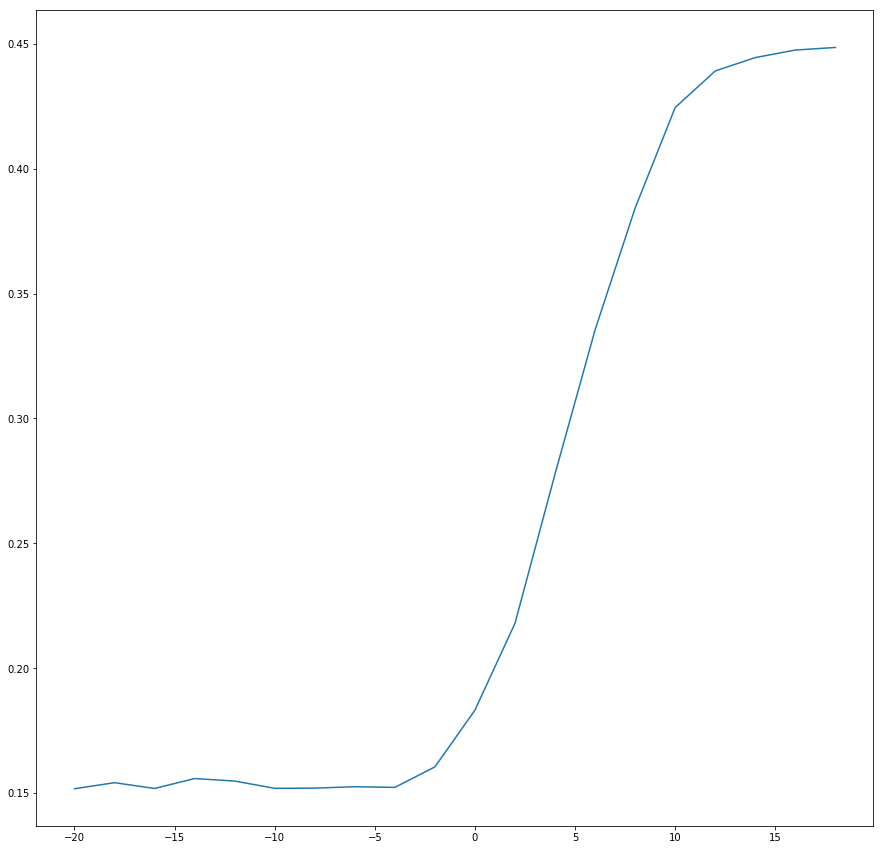

In [0]:
acc = []
sig_ = int(len(test_data) / (len(snrs) * len(mods)))
count = 0;
for i in trange(200):
  for j in trange(sig_):
    if(rounded_pred[j + sig_ * i] == test_lbl_encoded[j + sig_ * i]):
      count+=1
  acc.append(1-(count/sig_))
  count = 0
  
avg = []
print(len(acc))
for i in trange(len(snrs)):
  avg.append(sum(acc[i::len(snrs)])/len(snrs))
  
print(len(avg))
accur =np.array(acc)
plt.plot(snrs,avg[::-1])
print(avg)
# plt.plot(lbl,acc[10::20])

## 2.

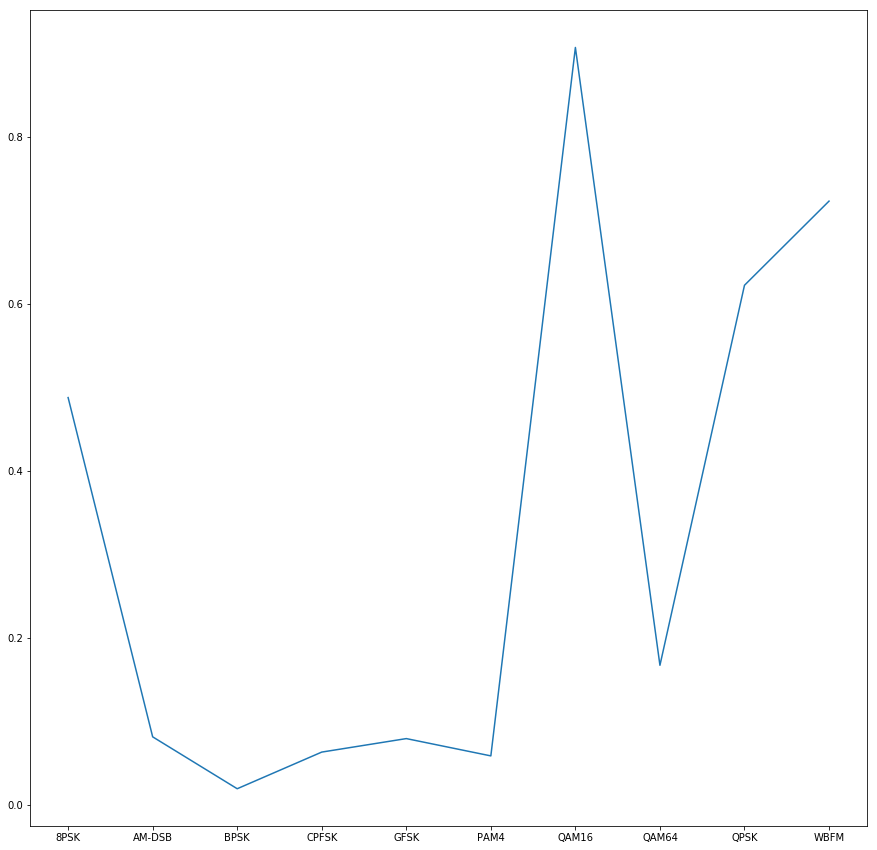

In [0]:
plt.plot(mods,acc[10::20])

###3. Show confusion matrices and find the most confusing classes.

[[21019  1416  2541 12415  1781    24   766   681 15816   541]
 [ 4571 41284  1457  2592  1291     9    10     0  1918  3868]
 [ 8507  1479 37780  5147  1057   500    49    13  1832   636]
 [ 8817  1452  2314 39512  2360    30   101    56  1786   572]
 [ 6693  2141  1920  6528 35522    26    56    44  1647  2423]
 [ 6046  1085  9597  3949   899 33622    51    11  1323   417]
 [11772   800  1783  6340  1144   181  4267 27510  2861   342]
 [ 8863   515  1269  5182   911   192  3750 34356  1699   263]
 [18000  1395  2612 12787  1674    28   701   666 18565   572]
 [ 4809 30167  1510  2952  4574    11    15     4  1896 11062]]
[b'8PSK', b'AM-DSB', b'BPSK', b'CPFSK', b'GFSK', b'PAM4', b'QAM16', b'QAM64', b'QPSK', b'WBFM']


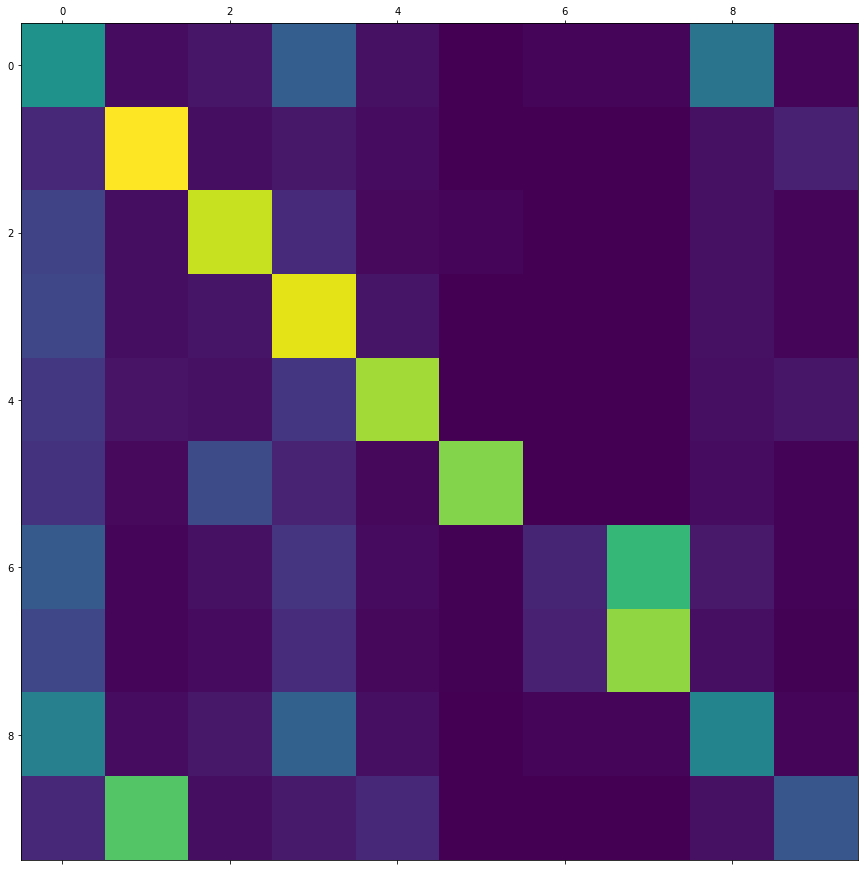

In [0]:
# def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
#     plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
#     tick_marks = np.arange(len(labels))
#     plt.xticks(tick_marks, labels, rotation=45)
#     plt.yticks(tick_marks, labels)
#     plt.tight_layout()
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')
    
# plot_confusion_matrix(cm, labels=test_lbl)
cm = confusion_matrix(test_lbl_encoded, rounded_pred)

 
print(cm)
plt.matshow(cm)
print(mods)